# 12. Revisiting the single-spore experiments

## Numerical experiments - Week 15/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

Having refined the models and obtained more insight into the diffusive properties of molecules in _Aspergillus_ conidia, the inhibitor release from a single spore is simulated under several assumed diffusion and permeation constants and multiple estimated permeation constants for targeted 4-hour depletion percentages.

## Prerequisite libraries

In [2]:
using PyPlot
using CurveFit
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis

┌ Warning: Module CUDA with build ID ffffffff-ffff-ffff-0000-9ca560dd8dd9 is missing from the cache.
│ This may mean CUDA [052768ef-5323-5732-b1bb-66c8b64840ba] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
┌ Error: Error during loading of extension AtomixCUDAExt of Atomix, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
│    Stacktrace:
│      [1] _require(pkg::Base.PkgId, env::Nothing)
│        @ Base .\loading.jl:1999
│      [2] __require_prelocked(uuidkey::Base.PkgId, env::Nothing)
│        @ Base .\loading.jl:1812
│      [3] #invoke_in_world#3
│        @ .\essentials.jl:926 [inlined]
│      [4] invoke_in_world
│        @ .\essentials.jl:923 [inlined]
│      [5] _require_prelocked
│        @ .\loading.jl:1803 [inlined]
│      [6] _require_prelocked
│        @ .\loading.jl:1802 [inlined]
│      [7] run_

## 1. Estimating the constants

### 1.1. Diffusion constants

#### 1.1.1. Known values

Several permeativities of analogue systems are known:

- the diffusion constant of glucose in water is $D=6\times10^{-6}\ \textrm{cm}^2/\textrm{s}=600\ \mu\textrm{m}^2/\textrm{s}$ [1];
- the diffusion constant of glucose in an agarose film is $D=6.38\times10^{-6}\ \textrm{cm}^2/\textrm{s}=638\ \mu\textrm{m}^2/\textrm{s}$ [2];
- the diffusion constant of glucose in cellulose nanofibrils is $D=1.7\times10^{-7}\ \textrm{cm}^2/\textrm{s}=17\ \mu\textrm{m}^2/\textrm{s}$ [3].

#### 1.1.2. Diffusion constants of 1-Octen-3-ol

The diffusion constant of 1-Octen-3-ol in water can be obtained from the Stokes-Einstein relation

$$
D=\frac{k_BT}{6\pi\eta a},
$$

considering a temperature of $T=303.15\ \textrm{K}$ (a common cultivation temperature for _Aspergillus_ conidia) and thus a thermodynamic constant of $k_BT=4.18\times10^{-21}\ \textrm{J}$.

The Stokes radius of 1-octen-3-ol can be computed from its volume, which is obtained by multiplying its molecular mass $m_M$ by its average density $\rho$. Since

$$
m_M(\textrm{1-octen-3-ol})=128.21\ \textrm{g/mol},
$$

$$
\rho(\textrm{1-octen-3-ol})=0.837\ \textrm{g/mL},
$$

the molecular volume is

$$
V_M(\textrm{1-octen-3-ol})=\frac{128.21\ \textrm{g/mol}}{0.837\ \textrm{g/mL}\cdot 6.022\times10^{23}\ \textrm{mol}^{-1}}\approx 2.54364\times 10^{-24}\ \textrm{mL},
$$

which yields a Stokes radius of

$$
a(\textrm{1-octen-3-ol}) = \left(\frac{3}{4\pi}V_M\right)^{1/3}=0.393\ \textrm{nm}.
$$

Using the viscosity of water at $303.15 \textrm{K}$,

$$
\eta(\textrm{water})=0.797 \ \textrm{mPa s},
$$

one arrives at

$$
D(\textrm{1-octen-3-ol in water})\approx 6.9016\times 10^{-6}\ \textrm{cm}^2/\textrm{s}=690.16\ \mu\textrm{m}^2/\textrm{s}.
$$

Since the Stokes radius of glucose is approximately $0.36\ \textrm{nm}$, one can obtain a comparable diffusion constant for glucose using the ratio of the Stokes radii:

$$
D(\textrm{glucose in water})=\frac{a(\textrm{1-octen-3-ol})}{a(\textrm{glucose})}\times D(\textrm{1-octen-3-ol in water})\approx 7.534\times 10^{-6}\ \textrm{cm}^2/\textrm{s}=753.4\ \mu\textrm{m}^2/\textrm{s}.
$$

This value is slightly higher than the constant found in literature, possibly due to the sensitivity of the water viscosity $\eta$ to temperature. Conversely, the ratio of the Stokes radii can be used to relate the other known diffusion constants of glucose to those of 1-octen-3-ol. Similar to glucose, the diffusivity of 1-octen-3-ol in an agarose film would be comparable to its diffusivity in water. In cellulose, the diffusion coefficient would be

$$
D(\textrm{1-octen-3-ol in cellulose})\approx \frac{a(\textrm{glucose})}{a(\textrm{1-octen-3-ol})}\times D(\textrm{glucose in cellulose})= 1.56\times 10^{-7}\ \textrm{cm}^2/\textrm{s}=15.6\ \mu\textrm{m}^2/\textrm{s}.
$$

In [31]:
# Calculation of diffusion constant
a = compute_stokes_radius(128.21, 0.822)
println("Stokes radius: ", a)
compute_D_from_radius_and_viscosity(a, 0.797)

Molecular volume: 2.590057057617608e-10
Stokes radius: 0.00039543360500816373


690.161673634019

#### 1.1.4. Diffusion constants of other VOCs

3-octanone is a structural isomer of 1-octen-3-ol and has the same molecular weight and an almost identical density of $0.822\ \textrm{g/mL}$. 3-octanol has a molecular weight of $130.23\ \textrm{g/mol}$ and a density of $0.818\ \textrm{g/mL}$, yielding a Stokes radius of approximately the same size as 1-octen-3-ol and a negligibly different diffusion constant. Hence, the diffusivity of the three VOCs can be considered equivalent.

In [32]:
# Calculation of diffusion constant
a = compute_stokes_radius(130.23, 0.818)
println("Stokes radius: ", a)
compute_D_from_radius_and_viscosity(a, 0.797)

Molecular volume: 2.643729308752991e-10
Stokes radius: 0.000398146398994561


685.4592163404097

#### 1.1.4. Diffusion constants of a heat-labile peptide

Assuming a protein with a Stokes radius of $6.0\ \textrm{nm}$, which is the upper limit of the experimentally observed molecular passages through the conidial cell wall [4], a diffusion constant through water,

$$
D(\textrm{heat-labile peptide in water})\approx 4.54855\times 10^{-7}\ \textrm{cm}^2/\textrm{s}=45.4855\ \mu\textrm{m}^2/\textrm{s},
$$

can be approximated using the Stokes-Einstein relation. Relating the size of the molecule to that of glucose, the diffusivity of the protein through cellulose could be roughly estimated:

$$
D(\textrm{heat-labile peptide in cellulose})\approx \frac{a(\textrm{glucose})}{a(\textrm{heat-labile peptide})}\times D(\textrm{glucose in cellulose})= 1.02\times 10^{-8}\ \textrm{cm}^2/\textrm{s}=1.02\ \mu\textrm{m}^2/\textrm{s}.$$

In [60]:
# Calculation of diffusion constant
a = 6.0 # nm
um2_to_cm2(compute_D_from_radius_and_viscosity(nm_to_um(a), 0.797))

4.5485519773927985e-7

### 1.2. Permeation constants

#### 1.2.1. Known values

The permeation constant of glucose in synthetic lipid bylayer found in literature is $P_s=1.4\times10^{-10}\ \textrm{cm/s}$ [5] or $P_s=2.4\times10^{-10}\ \textrm{cm/s}$ [6]. A rough average of $P_s=2.0\times10^{-10}\ \textrm{cm/s}$ is taken.

Using the Meyer-Overton rule,

$$
P_s=\frac{KD}{d},
$$

a lipid bilayer thickness $d=3.8\ \textrm{nm}$ in its liquid phase [7] and the octanol-water partition coefficient of glucose, $K=6.31\times 10^{-4}$ ($\log{K}=-3.2$) [8], the diffusion of glucose through the lipid bilayer can be quantified as

$$
D=\frac{P_sd}{K}=\frac{2.4\times10^{-10}\ \textrm{cm/s}\cdot 3.8\times 10^{-7}\ \textrm{cm}}{6.31\times 10^{-4}}\approx 1.18\times 10^{-13}\ \textrm{cm}^2/\textrm{s}=1.18\times 10^{-5}\ \mu\textrm{m}^2/\textrm{s}.
$$

In [40]:
# Calculation of diffusion constant
D = convert_Ps_to_D(cm_to_um(2e-10), 6.41e-4, nm_to_um(3.8))

1.185647425897036e-5

#### 1.2.2. Permeation constants of 1-octen-3-ol

1-octen-3-ol is less polar than glucose and its octanol-water partition coefficient is $K=316.23$ ($\log{K}=2.5$). If its diffusivity in lipid bilayers is related to the $D$ coefficient of glucose via the Stokes radii, then the Meyer-Overton rule can be used to obtain its permeation coefficient

$$
P_s(\textrm{1-octen-3-ol through lipid bilayer})=\frac{K(\textrm{1-octen-3-ol})\cdot D(\textrm{glucose in lipid bilayer})}{d}\cdot\frac{a(\textrm{glucose})}{a(\textrm{1-octen-3-ol})}\approx 9.04\times10^{-5}\ \textrm{cm/s}=0.904\ \mu\textrm{m/s}.
$$

This would describe a scenario in which the cell membrane is the rate-limiting layer of the spore envelope.

In [ ]:
# Calculation of permeation constant
convert_D_to_Ps(D, 316.23, nm_to_um(3.8)) * 0.36 / 0.393

0.0038

The Meyer-Overton rule generally does not apply in the same form to barriers different from lipid bilayers. In porous barriers, filled with water, that weakly interact with the solute, the partition coefficient can be approximated to $K\approx 1$, indicating a lack of preference for the molecule to reside inside or outside the barrier. Other factors like the porosity of the barrier can be assimilated in an effective permeation constant

$$
P_{\textrm{eff}}\approx\frac{D}{d}.
$$

It is hereby assumed that there is a rate-limiting permeability of the cell wall components, equivalent to the permeability of a specific substance, which determines the release of the inhibitor from the spore. The upper limit of the cell wall thickness in _Aspergillus_ conidia ($400\ \textrm{nm}$) [9] can be used to transform the estimated diffusion constants of 1-octen-3-ol into permeation constants:

$$
P_{\textrm{eff}}(\textrm{1-octen-3-ol through agarose})=\frac{D(\textrm{1-octen-3-ol in agarose})}{d}\approx\frac{D(\textrm{1-octen-3-ol in water})}{d}=\frac{690\ \mu\textrm{m}^2/\textrm{s}}{0.4\ \mu\textrm{m}}=0.1725\ \textrm{cm/s}=1725\ \mu\textrm{m/s},
$$

In [48]:
# Calculation of permeation constant
convert_D_to_Ps(690, 1, 0.4)

1725.0

$$
P_{\textrm{eff}}(\textrm{1-octen-3-ol through cellulose})=\frac{D(\textrm{1-octen-3-ol in cellulose})}{d}=\frac{15.6\ \mu\textrm{m}^2/\textrm{s}}{0.4\ \mu\textrm{m}}=0.0039\ \textrm{cm/s}=39\ \mu\textrm{m/s}.
$$

In [50]:
# Calculation of permeation constant
convert_D_to_Ps(15.6, 1, 0.4)

39.0

#### 1.2.3. Permeation constants of a heat-labile peptide

It is generally difficult to narrow down the range of partition coefficients for potential inhibitor proteins due to their size and complexity. Furthermore, in natural scenarios, proteins usually permeate cell membranes with the help of channels or transporters. Therefore, a permeation constant cannot be obtained in this case.

Regarding barriers of polysaccharides, the previously used approach can be applied to link the estimated diffusion constants to permeation constants:

$$
P_{\textrm{eff}}(\textrm{heat-labile peptide through agarose})=\frac{D(\textrm{heat-labile peptide in agarose})}{d}\approx\frac{D(\textrm{heat-labile peptide in water})}{d}=\frac{45.4855}{0.4\ \mu\textrm{m}}=0.011371375\ \textrm{cm/s}=113.71375\ \mu\textrm{m/s},
$$

In [62]:
# Calculation of permeation constant
convert_D_to_Ps(45.4855, 1, 0.4)

113.71375

$$
P_{\textrm{eff}}(\textrm{heat-labile peptide through cellulose})=\frac{D(\textrm{heat-labile peptide in cellulose})}{d}=\frac{1.02\ \mu\textrm{m}^2/\textrm{s}}{0.4\ \mu\textrm{m}}=2.55\times 10^{-4}\ \textrm{cm/s}=2.55\ \mu\textrm{m/s}.
$$

In [55]:
# Calculation of permeation constant
convert_D_to_Ps(1.02, 1, 0.4)

2.55

### 1.3. Summary

The following table summarises the diffusivities of different inhibitor candidates through rate-limiting barrier types:

|                                    | 1-octen-3-ol | heat-labile peptide |
|------------------------------------|--------------|---------------------|
|water                               |$D=6.9016\times 10^{-6}\ \textrm{cm}^2/\textrm{s}$|$D=4.54855\times 10^{-7}\ \textrm{cm}^2/\textrm{s}$|
|lipid bilayer membrane              |$P_s=2.0\times10^{-10}\ \textrm{cm/s}$|N/A|
|agarose-like cell wall (400 nm)     |$P_{\textrm{eff}}=0.1725\ \textrm{cm/s}$|$P_{\textrm{eff}}=0.011371375\ \textrm{cm/s}$|
|cellulose-like cell wall (400 nm)   |$P_{\textrm{eff}}=0.0039\ \textrm{cm/s}$|$P_{\textrm{eff}}=2.55\times 10^{-4}\ \textrm{cm/s}$|

## 2. Four-hour concentration drops

Without knowing the precise mechanisms of inhibition, it is difficult to establish how much the concentration of the inhibitor decreases in the 4-hour period prior to the swelling phase. However, an attempt can be made to infer these from experiments with _A. nidulans_ [10], where both the effect of spore crowding and of added 1-octen-3-ol have been measured.

The documented impact of spore density on the germination is as follows:

|Conidia/mL|$1\times 10^3$|$1\times 10^4$|$1\times 10^5$|$1\times 10^6$|$1\times 10^7$|$1\times 10^8$|
|----------|--------------|--------------|--------------|--------------|--------------|--------------|
|% Germination|$91.3\pm7.1$|$92.5\pm7.4$|$83\pm7.0$|$72\pm6.1$|$17\pm0.3$|$8\pm0.3$|

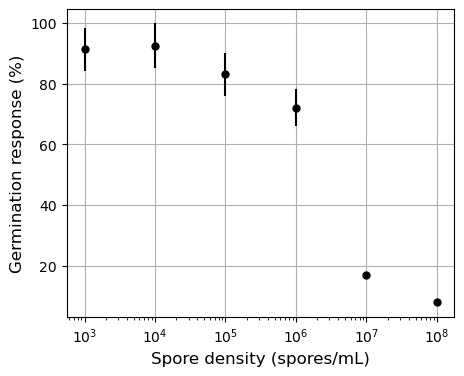

In [10]:
spore_densities = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
germination_responses = [91.3, 92.5, 83.0, 72.0, 17.0, 8.0]
confidence_intervals = [7.1, 7.4, 7.0, 6.1, 0.3, 0.3]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
# ax.semilogx(spore_densities, germination_responses, "o", color="black", markersize=5, label="Germination response")
ax.errorbar(spore_densities, germination_responses, yerr=confidence_intervals, fmt="o", color="black", markersize=5, label="Germination response")
ax.set_xlabel("Spore density (spores/mL)", fontsize=12)
ax.set_ylabel("Germination response (%)", fontsize=12)
ax.set_xscale("log")
ax.grid()

gcf()

The effect of added 1-octen-3-ol concentrations to a spore inoculum of density $10^6$ spores/mL is as follows:

|mM|1.0|2.5|4.0|5.0|
|----------|--------------|--------------|--------------|--------------|
|% Germination|$87\pm6.1$|$36\pm4.3$|$14\pm2.1$|$1\pm0.3$|

The control experiment yields a germination success of $95\pm5.3\%$.

[0.9157894736842105, 0.37894736842105264, 0.14736842105263157, 0.010526315789473684]


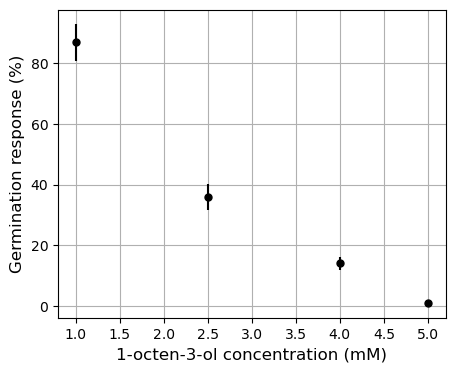

In [20]:
concentrations = [1.0, 2.5, 4.0, 5.0]
germination_responses = [87, 36, 14, 1]
confidence_intervals = [6.1, 4.3, 2.1, 0.3]

println(germination_responses./95)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
# ax.plot(concentrations, germination_responses, "o", color="black", markersize=5, label="Germination response")
ax.errorbar(concentrations, germination_responses, yerr=confidence_intervals, fmt="o", color="black", markersize=5, label="Germination response")
ax.set_xlabel("1-octen-3-ol concentration (mM)", fontsize=12)
ax.set_ylabel("Germination response (%)", fontsize=12)
ax.grid()

gcf()

Following our hypothesis and the inhibitor saturation model derived earlier, the concentration of inhibitor in the spore follows the formula

$$
\begin{equation}
    c_{\textrm{in}}(t) = \left(c_0 + c_{\textrm{out}}\right)e^{-\frac{t}{\tau}}.
\end{equation}
$$

In the case of saturation driven by spore density, $c_{\textrm{out}}$ dynamically increases as the spores release more inhibitor, counteracting the exponential decay:

$$
\begin{equation}
    c_{\textrm{out}}=c_0\rho_s\frac{AP_s}{4\pi D^{3/2}}\int_0^{R_{\textrm{diff}}}{d{r}\ r^2\int_0^t{t'^{-3/2}e^{\left(\tau t'-\frac{r^2}{4Dt'}\right)}dt'}}=c_0\lambda_{\textrm{add}},
\end{equation}
$$

where $\lambda_{\textrm{add}}$ is the spatio-temporal integral that accounts for the inhibitor release in the neighbourhood. Thus,

$$
\begin{equation}
    c_{\textrm{in}}(t) = c_0\left(1 + \lambda_{\textrm{add}}\right)e^{-\frac{t}{\tau}}
\end{equation}
$$

and the relative concentration drop is

$$
\begin{equation}
    \frac{c_{\textrm{in}}(t)}{c_0} = \left(1 + \lambda_{\textrm{add}}\right)e^{-\frac{t}{\tau}}.
\end{equation}
$$

In the case of exogenously added inhibitor, a constant concentration $c_{\textrm{ex}}$ is added to the external inhibitor quantity, such that

$$
\begin{equation}
    c_{\textrm{out}}=c_0\lambda_{\textrm{add}}'+c_{\textrm{ex}},
\end{equation}
$$

where $\lambda_{\textrm{add}}'$ accounts for the external inhibitor deposition at the reference inoculum density $\rho_s=10^6$.

Hence,

$$
\begin{equation}
    c_{\textrm{in}}(t) = c_0\left(1 + \lambda_{\textrm{add}}'+\frac{c_{\textrm{ex}}}{c_0}\right)e^{-\frac{t}{\tau}}
\end{equation}
$$

and the relative concentration drop is

$$
\begin{equation}
    \frac{c_{\textrm{in}}(t)}{c_0} = \left(1 + \lambda_{\textrm{add}}'+\frac{c_{\textrm{ex}}}{c_0}\right)e^{-\frac{t}{\tau}}.
\end{equation}
$$


## References

- [1] Höber, R. Physikalische Chemie der Zelle und der Gewebe. Nature, 112, 93-93.
- [2] Zhang, T., & Fang, H. (2005). Effective Diffusion Coefficients of Glucose in Artificial Biofilms. Environmental Technology, 26, 155 - 160.
- [3] Carter, N., Towne, J., & Neivandt, D.J. (2021). Finite element analysis of glucose diffusivity in cellulose nanofibril peripheral nerve conduits. Cellulose, 28, 2791 - 2803.
- [4] Brul, S., Nussbaum, J., & Dielbandhoesing, S.K. (1997). Fluorescent probes for wall porosity and membrane integrity in filamentous fungi. Journal of Microbiological Methods, 28, 169-178.
- [5] Bresseleers, G.J., Goderis, H.L., & Tobback, P. (1984). Measurement of the glucose permeation rate across phospholipid bilayers using small unilamellar vesicles. Effect of membrane composition and temperature. Biochimica et biophysica acta, 772 3, 374-82 .
- [6] Jakubowski, H.V., Flatt, P., Agnew, H., & Larsen, D. (2022). Fundamentals of Biochemistry, a free and new LibreText book for Undergraduate Courses. The FASEB Journal, 36.
- [7] Yarrow, F., & Kuipers, B.W. (2011). AFM study of the thermotropic behaviour of supported DPPC bilayers with and without the model peptide WALP23. Chemistry and physics of lipids, 164 1, 9-15.
- [8] Mazzobre, M.F., Román, M., Mourelle, A.F., & Corti, H.R. (2005). Octanol-water partition coefficient of glucose, sucrose, and trehalose. Carbohydrate research, 340 6, 1207-11.
- [9] Beauvais, A., Bozza, S., Kniemeyer, O., Formosa, C., Balloy, V., Henry, C., Roberson, R.W., Dague, E., Chignard, M., Brakhage, A.A., Romani, L., & Latgé, J.P. (2013). Deletion of the α-(1,3)-Glucan Synthase Genes Induces a Restructuring of the Conidial Cell Wall Responsible for the Avirulence of Aspergillus fumigatus. PLoS Pathogens, 9.
- [10] Herrero-García, E., Garzia, A., Cordobés, S., Espeso, E.A., & Ugalde, U. (2011). 8-Carbon oxylipins inhibit germination and growth, and stimulate aerial conidiation in Aspergillus nidulans. Fungal biology, 115 4-5, 393-400 .